In [1]:
import scanpy as sc
import schist as scs
import pandas as pd
import anndata as ad
import sklearn.metrics
import pynndescent
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.settings.verbosity=2
sc.set_figure_params(dpi=80, dpi_save=300)

In [3]:
adata1 = scs.io.read("10XV3_075")
adata2 = scs.io.read("iCELL8_075")

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


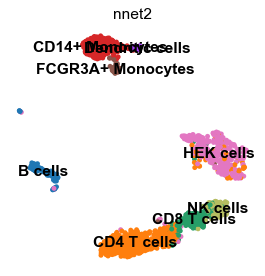

In [4]:
sc.pl.umap(adata1, color='nnet2', legend_loc='on data', frameon=False)

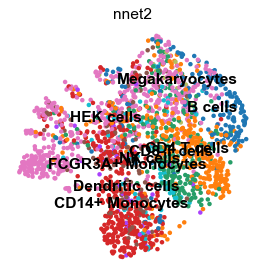

In [5]:
sc.pl.umap(adata2, color='nnet2', legend_loc='on data', frameon=False)

In [6]:
adata1.obs['annotation'] = adata1.obs['nnet2']
adata2.obs['annotation'] = 'Unknown'

In [7]:
mdata = adata1.concatenate(adata2, batch_categories=['10XV3', 'iCELL8'])
mdata.obs['annotation'] = pd.Categorical(mdata.obs['annotation'])

In [ ]:
sc.pp.scale(mdata)
sc.tl.pca(mdata)
sc.external.pp.harmony_integrate(mdata, key='batch')
sc.pp.neighbors(mdata, n_neighbors=int(np.sqrt(mdata.shape[0])/2), use_rep='X_pca_harmony')
sc.tl.umap(mdata)

computing PCA
    on highly variable genes
/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:03)
2021-07-16 11:23:24,147 - harmonypy - INFO - Iteration 1 of 10
2021-07-16 11:23:25,611 - harmonypy - INFO - Iteration 2 of 10
2021-07-16 11:23:26,725 - harmonypy - INFO - Iteration 3 of 10
2021-07-16 11:23:27,689 - harmonypy - INFO - Iteration 4 of 10
2021-07-16 11:23:28,690 - harmonypy - INFO - Iteration 5 of 10
2021-07-16 11:23:30,134 - harmonypy - INFO - Iteration 6 of 10
2021-07-16 11:23:31,410 - harmonypy - INFO - Iteration 7 of 10
2021-07-16 11:23:33,161 - harmonypy - INFO - Iteration 8 of 10
2021-07-16 11:23:34,276 - harmonypy - INFO - Iteration 9 of 10
2021-07-16 11:23:35,306 - harmonypy - INFO - Iteration 1

In [ ]:
scs.tl.calculate_affinity(mdata, group_by='annotation', neighbors_key='neighbors')

In [ ]:
categories = mdata.obs['annotation'].cat.categories
affinity = pd.DataFrame(mdata.obsm['CA_annotation'], index=mdata.obs_names, 
                        columns=categories)

In [ ]:
rank_affinity = affinity.rank(axis=1, ascending=False)
mdata.obs['reassigned'] = mdata.obs['annotation'].values
for c in rank_affinity.columns:
    cells = rank_affinity[rank_affinity[c] == 1].index
    mdata.obs.loc[cells, 'reassigned'] = c

In [ ]:
mdata_1 = mdata[mdata.obs['batch'] == "10XV3"]
mdata_2 = mdata[mdata.obs['batch'] != "10XV3"]
mdata_1.obs_names = [x.replace('-10XV3', '') for x in mdata_1.obs_names]
mdata_2.obs_names = [x.replace('-iCELL8', '') for x in mdata_2.obs_names]
n_neighbors = int(np.sqrt(mdata_1.shape[0])/2)
knn = pynndescent.NNDescent(mdata_1.obsm['X_pca_harmony'], n_neighbors=n_neighbors)

In [ ]:
closest = knn.query(mdata_2.obsm['X_pca_harmony'], k=1)[0]

In [ ]:
mdata_2.obs['knn_label'] = mdata_1.obs['annotation'].iloc[closest.ravel()].values

In [ ]:
adata2.obs['reassigned_schist'] = mdata_2.obs['reassigned']
adata2.obs['reassigned_knn'] = mdata_2.obs['knn_label']

In [ ]:
col_scheme = dict(zip(adata2.obs['nnet2'].cat.categories, adata2.uns['nnet2_colors']))

col_scheme['Unknown'] = '#f3f3f3'

In [18]:
adata2.uns['reassigned_schist_colors'] = [col_scheme[x] for x in adata2.obs['reassigned_schist'].cat.categories]
adata2.uns['reassigned_knn_colors'] = [col_scheme[x] for x in adata2.obs['reassigned_knn'].cat.categories]

In [19]:
rs_knn = sklearn.metrics.adjusted_rand_score(adata2.obs['nnet2'], 
                                           adata2.obs['reassigned_knn'])

rs_schist = sklearn.metrics.adjusted_rand_score(adata2.obs['nnet2'], 
                                           adata2.obs['reassigned_schist'])

... storing 'annotation' as categorical


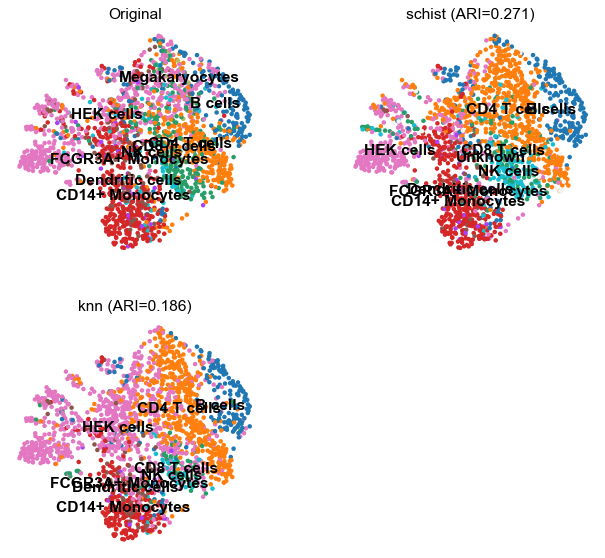

In [20]:
sc.pl.umap(adata2, color=['nnet2', 'reassigned_schist', 'reassigned_knn'], ncols=2, 
          title=['Original', f'schist (ARI={rs_schist:.3f})', f'knn (ARI={rs_knn:.3f})'],
           legend_loc='on data', frameon=False)

In [21]:
adata2.obs.query('nnet2 == "Megakaryocytes"')[['reassigned_schist', 'reassigned_knn']]

,reassigned_schist,reassigned_knn
ICELL8_023_CAACCAGAGAA,Unknown,HEK cells
ICELL8_022_TTCTAGGCGCT,CD4 T cells,CD4 T cells
ICELL8_020_AACTGAAGGAC,CD4 T cells,CD4 T cells
ICELL8_020_AAGACGGATTG,CD4 T cells,CD4 T cells
ICELL8_020_AAGAGACGGAA,CD4 T cells,CD4 T cells
ICELL8_020_AGAATATCGTC,CD4 T cells,CD4 T cells
ICELL8_020_ATGCGGAGTAC,CD4 T cells,CD4 T cells
ICELL8_020_CCAGCGCCAGT,CD4 T cells,CD4 T cells
ICELL8_020_CCATATGAAGA,CD4 T cells,CD4 T cells
ICELL8_020_CGAAGCCATCC,CD4 T cells,CD4 T cells


In [22]:
unassigned = adata2.obs.query('reassigned_schist == "Unknown"')[['nnet2', 'reassigned_knn']]

unassigned.index = [f'{x}-iCELL8' for x in unassigned.index]

unassigned_ranks = []
for cell in unassigned.index:
    truth = unassigned.loc[cell, 'nnet2']
    try:
        unassigned_ranks.append(rank_affinity.loc[cell, truth])
    except KeyError:
        continue

Text(0, 0.5, 'Fraction')

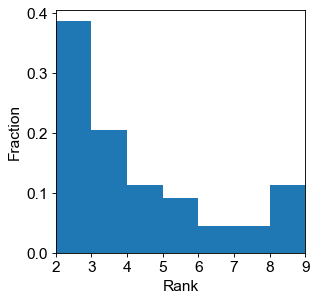

In [23]:
hist(unassigned_ranks, bins=range(1, 10), density=True)
grid()
xlim(2, 9)
xticks(range(2, 10))
xlabel("Rank")
ylabel("Fraction")